Use case yang ingin kita pecahkan menggunakan Machine Larning adalah Deteksi Dini Stunting menggunakan ANN. Disini kita akan menggunakan data training yang didapat dari `Kaggle` [](https://www.kaggle.com/datasets/rendiputra/stunting-balita-detection-121k-rows). Dataset berisikan lebih dari 120 ribu baris yang sudah dilabeli.

In [8]:
import pandas as pd
train = pd.read_csv("./data_balita.csv")

train.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


In [9]:
# Kita tampilkan dulu ringkasan informasi dari dataset diatas
train.info()

"""
Tampilkan statistik deskriptif dari dataset guna memastikan bahwa data yang digunakan
untuk melatih model machine learning adalah data yang representatif
"""
train.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120999 entries, 0 to 120998
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Umur (bulan)       120999 non-null  int64  
 1   Jenis Kelamin      120999 non-null  object 
 2   Tinggi Badan (cm)  120999 non-null  float64
 3   Status Gizi        120999 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
count,120999.000000,120999,120999.000000,120999
unique,NaN,2,NaN,4
top,NaN,perempuan,NaN,normal
freq,NaN,61002,NaN,67755
mean,30.173803,NaN,88.655434,NaN
std,17.575119,NaN,17.300997,NaN
min,0.000000,NaN,40.010437,NaN
25%,15.000000,NaN,77.000000,NaN
50%,30.000000,NaN,89.800000,NaN
75%,45.000000,NaN,101.200000,NaN


In [10]:
# Memeriksa jumlah nilai yang hilang di setiap kolom, pastikan model nya bagus
# Karena klo sampe ada data yang hilang modelnya bisa ga akurat nanti
missing_values = train.isnull().sum()
print("Jumlah data yang hilang Untuk masing-masing kolom")
print(missing_values)
missing_values[missing_values > 0]

Jumlah data yang hilang Untuk masing-masing kolom
Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64


Series([], dtype: int64)

In [11]:
# Kita tampilkan dulu data unique pada kolom kategorikal
print(train['Jenis Kelamin'].unique())
print(train['Status Gizi'].unique())

['laki-laki' 'perempuan']
['stunted' 'tinggi' 'normal' 'severely stunted']


Dari data ditas kita dapat melihat nilai unik untuk kolom `Jenis Kelamin` dan `Status Gizi`. Namun model machine learning membutuhkan data numerikal, sehingga kita butuh mapping data tersebut ke numerik.

In [12]:
# train['Jenis Kelamin'] = train['Jenis Kelamin'].str.lower().str.strip()
# train['Status Gizi'] = train['Status Gizi'].str.lower().str.strip()
print(train['Jenis Kelamin'].dtype)
train['Jenis Kelamin'] = train['Jenis Kelamin'].astype(str).str.strip().str.lower()
train['Status Gizi'] = train['Status Gizi'].astype(str).str.strip().str.lower()

train['Jenis Kelamin'] = train['Jenis Kelamin'].astype(str).map({'laki-laki': 0, 'perempuan': 1})
train['Status Gizi'] = train['Status Gizi'].astype(str).map({'normal': 0, 'tinggi': 1, 'severely stunted': 2, 'stunted': 3})
# Binary classification: Stunted or Not
train['Status Gizi'] = train['Status Gizi'].map({0: 0, 1: 0, 2: 1, 3: 1})

print(train['Jenis Kelamin'].unique())
print(train['Status Gizi'].unique())
# print(train.head())

object
[0 1]
[1 0]


Setelah dilakukan mapping sekarang coba kita visualisasikan dataset nya agar kita bisa melihat adakah outliers atau pola yang aneh pada data.

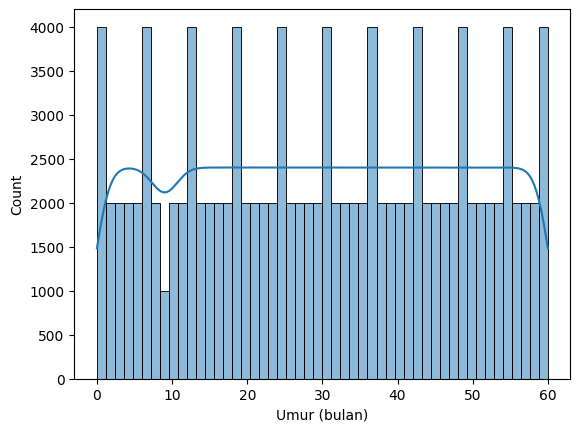

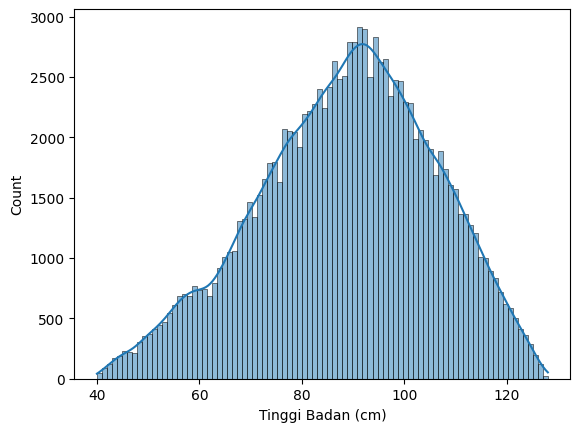

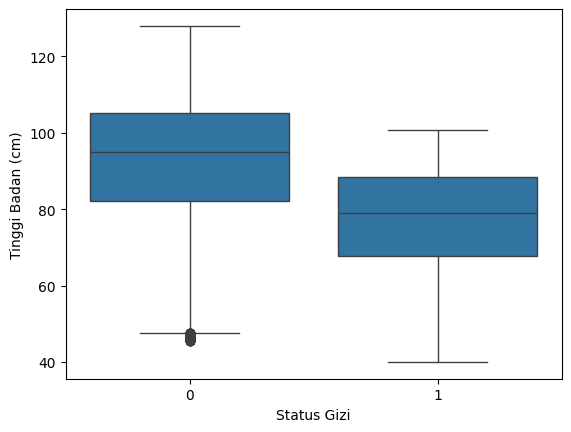

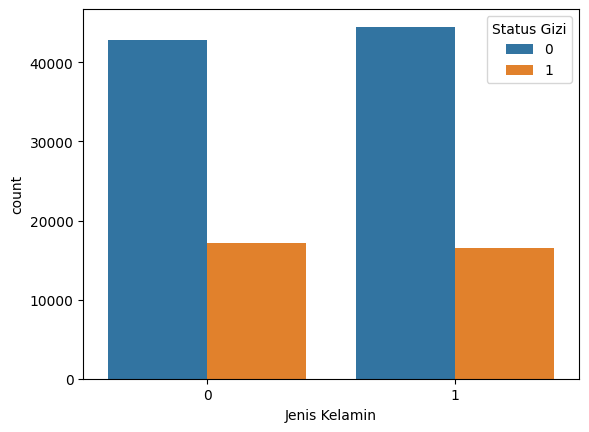

In [13]:
import seaborn as sns # ini lib untuk visualisasi datanyo
import matplotlib.pyplot as plt

# Histogram untuk umur
sns.histplot(train['Umur (bulan)'], kde=True)
plt.show()

# Histogram untuk Tinggi Badan
sns.histplot(train['Tinggi Badan (cm)'], kde=True)
plt.show()

# Hubungan antara fitur dan target
sns.boxplot(x='Status Gizi', y='Tinggi Badan (cm)', data=train)
plt.show()

# Sebaran data kategorikal
sns.countplot(x='Jenis Kelamin', hue='Status Gizi', data=train)
plt.show()

# check apakah ada data duplikat
# Mengidentifikasi baris duplikat
# duplicates = train.duplicated()
 
# print("Baris duplikat:")
# print(train[duplicates])
# Kode untuk check duplikat somehow agak aneh, data yang dibilang duplikat itu harusnya ga duplikat, ntar dicari lagi penyebabnya

Data telah kita pastikan bersih dan bisa digunakan untuk tahapan selanjutnya dimana kita akan memilih model dan melakukan training menggunakan dataset diatas.

In [14]:
from sklearn.model_selection import train_test_split

X = train[['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)']]
y = train['Status Gizi']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)

(96799, 3)


Dari output diatas kita simpulkan ada 96799 baris training dengan 3 kolom. Kita akan menggunakan library `Tensorflow` untuk melakukan training menggunakan ANN.

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

print(y_train[:5])
# Scale the data for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Buat jaringan syarafnya
# Kita akan gunakan 3 input
# Hidden Layer 1 16 neuron
# Hidden layer 2 8 neuron
# Output Layer dengan 1 neuron
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicitly specify the input shape
    Dense(16, activation='relu'),     # First hidden layer
    Dense(8, activation='relu'),      # Second hidden layer
    Dense(1, activation='sigmoid')    # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy}")

# Predictions and Evaluation
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


2024-11-24 06:56:14.520822: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 06:56:14.521532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 06:56:14.524657: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 06:56:14.531124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732406174.541193  156266 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732406174.54

21452    1
25283    0
30909    1
64536    0
68658    1
Name: Status Gizi, dtype: int64
Epoch 1/50


2024-11-24 06:56:15.610497: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


3025/3025 ━━━━━━━━━━━━━━━━━━━━ 4s 995us/step - accuracy: 0.8982 - loss: 0.2340 - val_accuracy: 0.9884 - val_loss: 0.0446
Epoch 2/50
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9876 - loss: 0.0396 - val_accuracy: 0.9904 - val_loss: 0.0321
Epoch 3/50
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 3s 845us/step - accuracy: 0.9908 - loss: 0.0280 - val_accuracy: 0.9914 - val_loss: 0.0235
Epoch 4/50
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 3s 997us/step - accuracy: 0.9919 - loss: 0.0227 - val_accuracy: 0.9932 - val_loss: 0.0199
Epoch 5/50
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 3s 877us/step - accuracy: 0.9931 - loss: 0.0195 - val_accuracy: 0.9947 - val_loss: 0.0179
Epoch 6/50
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 3s 921us/step - accuracy: 0.9931 - loss: 0.0185 - val_accuracy: 0.9938 - val_loss: 0.0170
Epoch 7/50
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9937 - loss: 0.0169 - val_accuracy: 0.9947 - val_loss: 0.0156
Epoch 8/50
3025/3025 ━━━━━━━━━━━━━━━━━━━━ 3s 960us/step - accuracy: 0.9938 - loss: 0.0161 -

Kita pastikan dulu tidak ada overfitting.

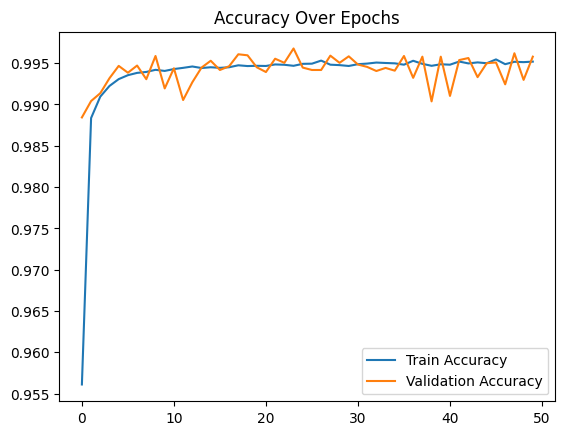

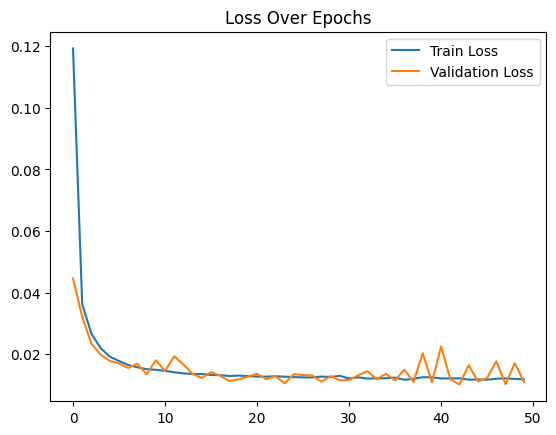

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()